# 01 - Image Deepfake Detection Baseline

## Objective
Compare multiple state-of-the-art image models for deepfake detection:
- **CLIP** (OpenAI) - Contrastive Language-Image Pretraining
- **DINOv2** (Meta) - Self-supervised Vision Transformer
- **ConvNeXt** - Modern ConvNet architecture
- **EfficientNetV2** - Efficient CNN with compound scaling

## Dataset
Using existing image datasets:
- Train: `Deepfake image detection dataset/train/`
- Test: `Deepfake image detection dataset/test/`

## Metrics
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC
- Confusion Matrix
- Training Time & Inference Speed

In [5]:
import torch
import sys

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
PyTorch: 2.9.1+cu128
CUDA Available: True
CUDA Version: 12.8
GPU: NVIDIA RTX A6000
GPU Memory: 48.31 GB


In [6]:
# Install required packages
!pip install -q transformers timm open_clip_torch opencv-python pillow scikit-learn
!pip install -q matplotlib seaborn tqdm

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# Image processing
from PIL import Image
import cv2

# Transformers and timm
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel
import timm

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

C:\Users\akshay-stu\miniconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [16]:
# Dataset paths
TRAIN_FAKE_DIR = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/fake'
TRAIN_REAL_DIR = '../Deepfake image detection dataset/train-20250112T065955Z-001/train/real'
TEST_FAKE_DIR = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/fake'
TEST_REAL_DIR = '../Deepfake image detection dataset/test-20250112T065939Z-001/test/real'

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

print("Configuration set!")

Configuration set!


In [17]:
class DeepfakeImageDataset(Dataset):
    def __init__(self, fake_dir, real_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load fake images
        if os.path.exists(fake_dir):
            for img_name in os.listdir(fake_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(fake_dir, img_name))
                    self.labels.append(1)  # 1 for fake
        
        # Load real images
        if os.path.exists(real_dir):
            for img_name in os.listdir(real_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(real_dir, img_name))
                    self.labels.append(0)  # 0 for real
        
        print(f"Loaded {len(self.image_paths)} images: {self.labels.count(0)} real, {self.labels.count(1)} fake")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image if error
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), label

print("Dataset class defined!")

Dataset class defined!


In [18]:
# Standard transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined!")

Transforms defined!


In [19]:
# Create datasets
print("Loading training data...")
train_dataset = DeepfakeImageDataset(TRAIN_FAKE_DIR, TRAIN_REAL_DIR, transform=train_transform)

print("\nLoading test data...")
test_dataset = DeepfakeImageDataset(TEST_FAKE_DIR, TEST_REAL_DIR, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Loading training data...
Loaded 479 images: 326 real, 153 fake

Loading test data...
Loaded 499 images: 110 real, 389 fake


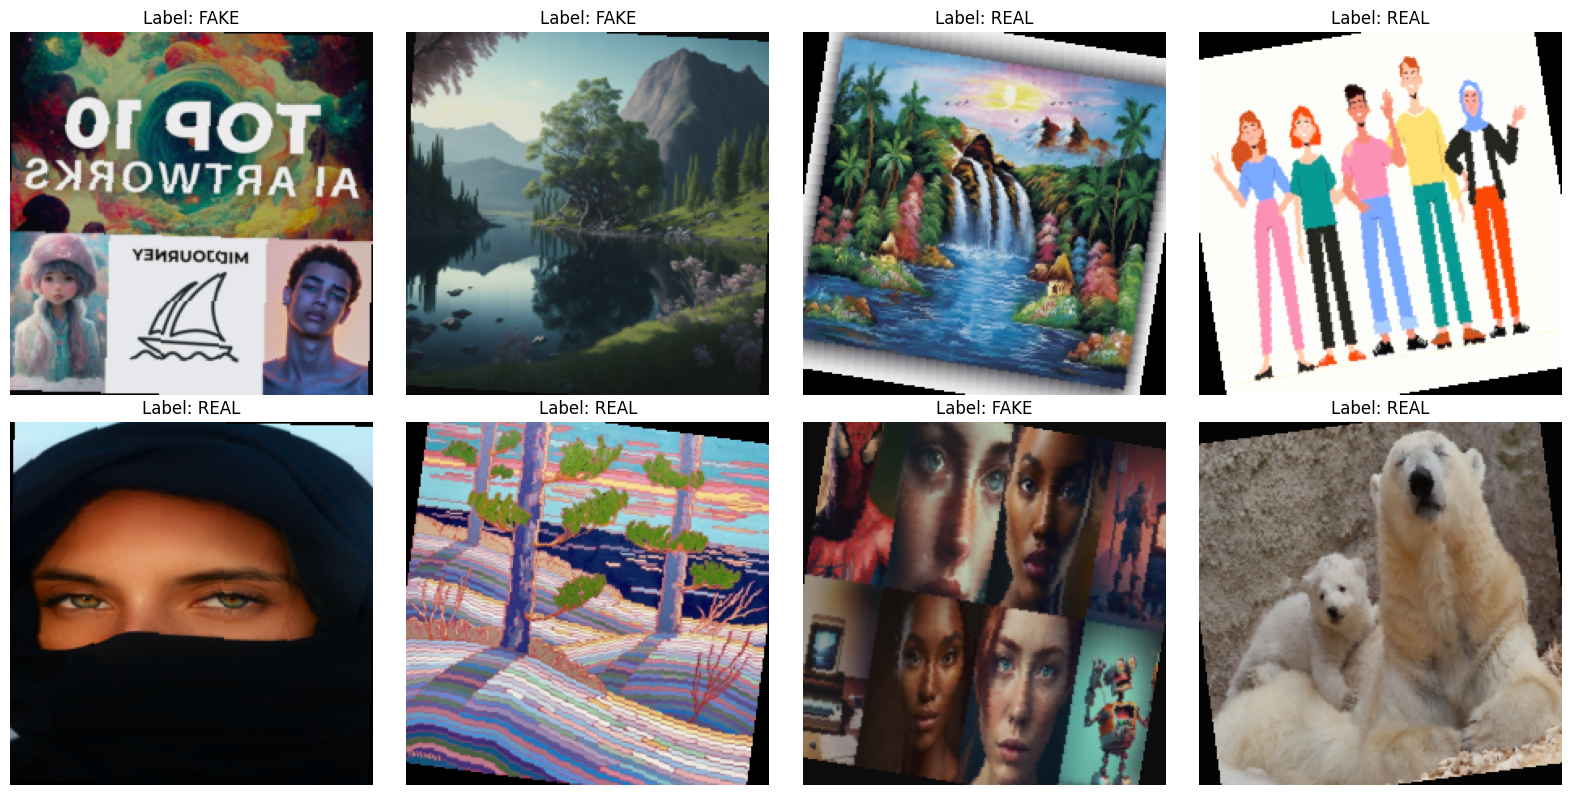

In [20]:
# Visualize some samples
def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # Denormalize
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {'FAKE' if label == 1 else 'REAL'}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

## Model 1: CLIP (Contrastive Language-Image Pretraining)

CLIP from OpenAI learns visual concepts from natural language supervision.
We'll use the vision encoder as a feature extractor.

In [21]:
class CLIPDeepfakeDetector(nn.Module):
    def __init__(self, clip_model_name='openai/clip-vit-base-patch32', freeze_backbone=True):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        
        if freeze_backbone:
            for param in self.clip.parameters():
                param.requires_grad = False
        
        # Get feature dimension
        self.feature_dim = self.clip.config.projection_dim
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # Binary classification
        )
    
    def forward(self, x):
        features = self.clip.get_image_features(pixel_values=x)
        output = self.classifier(features)
        return output

print("CLIP model class defined!")

CLIP model class defined!


## Model 2: DINOv2 (Self-supervised Vision Transformer)

DINOv2 from Meta is a self-supervised ViT that learns robust visual features.

In [22]:
class DINOv2DeepfakeDetector(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base', freeze_backbone=True):
        super().__init__()
        self.dino = AutoModel.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.dino.parameters():
                param.requires_grad = False
        
        # Get feature dimension
        self.feature_dim = self.dino.config.hidden_size
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        outputs = self.dino(x)
        # Use CLS token
        features = outputs.last_hidden_state[:, 0]
        output = self.classifier(features)
        return output

print("DINOv2 model class defined!")

DINOv2 model class defined!


## Model 3: ConvNeXt

ConvNeXt is a modernized ConvNet that matches ViT performance.

In [23]:
class ConvNeXtDeepfakeDetector(nn.Module):
    def __init__(self, model_name='convnext_base', freeze_backbone=True):
        super().__init__()
        self.convnext = timm.create_model(model_name, pretrained=True, num_classes=0)  # Remove head
        
        if freeze_backbone:
            for param in self.convnext.parameters():
                param.requires_grad = False
        
        # Get feature dimension
        self.feature_dim = self.convnext.num_features
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        features = self.convnext(x)
        output = self.classifier(features)
        return output

print("ConvNeXt model class defined!")

ConvNeXt model class defined!


## Model 4: EfficientNetV2

EfficientNetV2 uses compound scaling and is optimized for training speed.

In [24]:
class EfficientNetV2DeepfakeDetector(nn.Module):
    def __init__(self, model_name='tf_efficientnetv2_b3', freeze_backbone=True):
        super().__init__()
        self.efficientnet = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        if freeze_backbone:
            for param in self.efficientnet.parameters():
                param.requires_grad = False
        
        # Get feature dimension
        self.feature_dim = self.efficientnet.num_features
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        features = self.efficientnet(x)
        output = self.classifier(features)
        return output

print("EfficientNetV2 model class defined!")

EfficientNetV2 model class defined!


## Training and Evaluation Functions

In [25]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of fake class
    
    return running_loss / len(test_loader), all_preds, all_labels, all_probs

print("Training functions defined!")

Training functions defined!


In [26]:
def calculate_metrics(y_true, y_pred, y_probs):
    """Calculate comprehensive metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1': f1_score(y_true, y_pred, average='binary'),
        'roc_auc': roc_auc_score(y_true, y_probs)
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_probs, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

print("Metrics functions defined!")

Metrics functions defined!


In [27]:
def train_model(model, model_name, train_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    """Complete training pipeline for a model"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_acc = 0.0
    best_model_state = None
    
    import time
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 40)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Evaluate
        val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"✓ New best accuracy: {best_acc:.2f}%")
        
        scheduler.step()
    
    training_time = time.time() - start_time
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    print(f"\nFinal evaluation on best model...")
    _, final_preds, final_labels, final_probs = evaluate(model, test_loader, criterion, device)
    
    # Calculate metrics
    metrics = calculate_metrics(final_labels, final_preds, final_probs)
    metrics['training_time'] = training_time
    metrics['best_val_acc'] = best_acc
    
    print(f"\n{model_name} Final Results:")
    print("-" * 40)
    for key, value in metrics.items():
        if key == 'training_time':
            print(f"{key}: {value:.2f}s ({value/60:.2f} min)")
        else:
            print(f"{key}: {value:.4f}")
    
    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(train_losses, label='Train Loss', marker='o')
    axes[0].plot(val_losses, label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss Curves')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(train_accs, label='Train Acc', marker='o')
    axes[1].plot(val_accs, label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy Curves')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix and ROC
    plot_confusion_matrix(final_labels, final_preds, title=f'{model_name} - Confusion Matrix')
    plot_roc_curve(final_labels, final_probs, title=f'{model_name} - ROC Curve')
    
    return model, metrics, {'preds': final_preds, 'labels': final_labels, 'probs': final_probs}

print("Training wrapper defined!")

Training wrapper defined!


## Train All Models

Now we'll train all four models and compare their performance.

In [28]:
# Dictionary to store results
results = {}

# Note: CLIP requires special preprocessing, we'll handle it separately
# For now, let's train the other three models that use standard ImageNet preprocessing

print("Starting model training pipeline...\n")

Starting model training pipeline...




Training ConvNeXt


Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


Train Loss: 0.6427, Train Acc: 64.30%
Val Loss: 0.8086, Val Acc: 25.65%
✓ New best accuracy: 25.65%

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.5631, Train Acc: 69.94%
Val Loss: 0.7976, Val Acc: 36.07%
✓ New best accuracy: 36.07%

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.5045, Train Acc: 75.57%
Val Loss: 0.6973, Val Acc: 54.71%
✓ New best accuracy: 54.71%

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.4540, Train Acc: 82.05%
Val Loss: 0.6540, Val Acc: 60.12%
✓ New best accuracy: 60.12%

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.4017, Train Acc: 83.92%
Val Loss: 0.5999, Val Acc: 63.93%
✓ New best accuracy: 63.93%

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 0.3668, Train Acc: 86.01%
Val Loss: 0.5648, Val Acc: 67.94%
✓ New best accuracy: 67.94%

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


Train Loss: 0.3431, Train Acc: 88.94%
Val Loss: 0.5585, Val Acc: 68.54%
✓ New best accuracy: 68.54%

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 0.3198, Train Acc: 89.14%
Val Loss: 0.5534, Val Acc: 68.34%

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 0.3138, Train Acc: 89.35%
Val Loss: 0.5515, Val Acc: 68.14%

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.3085, Train Acc: 89.98%
Val Loss: 0.5522, Val Acc: 67.94%

Final evaluation on best model...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]



ConvNeXt Final Results:
----------------------------------------
accuracy: 0.6794
precision: 0.9712
recall: 0.6067
f1: 0.7468
roc_auc: 0.8787
training_time: 381.22s (6.35 min)
best_val_acc: 68.5371


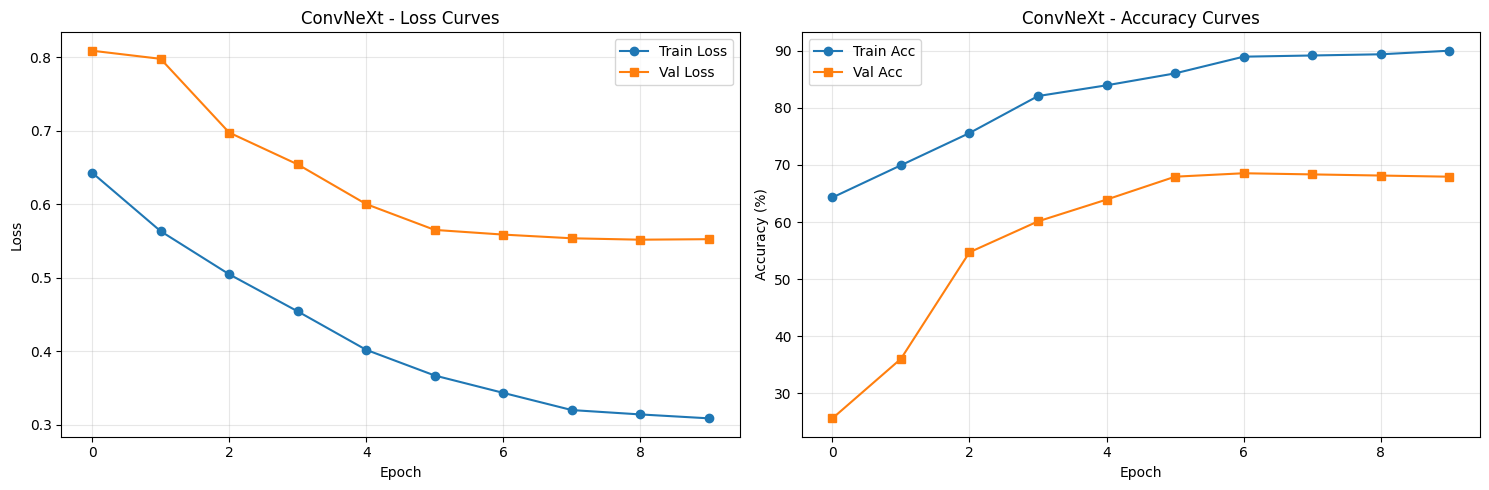

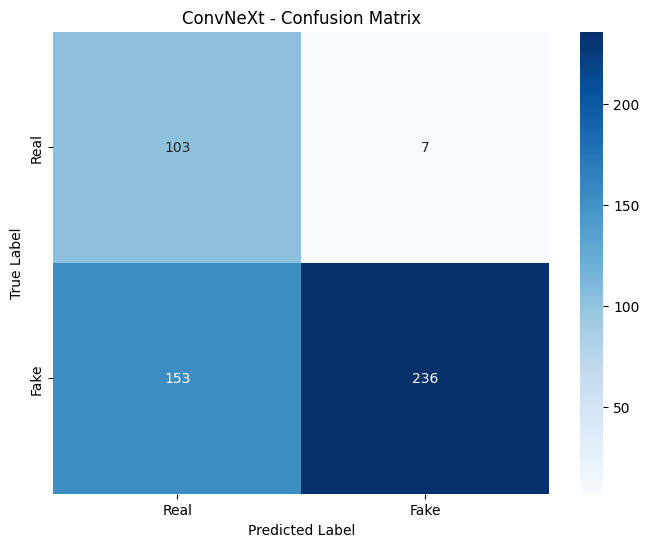

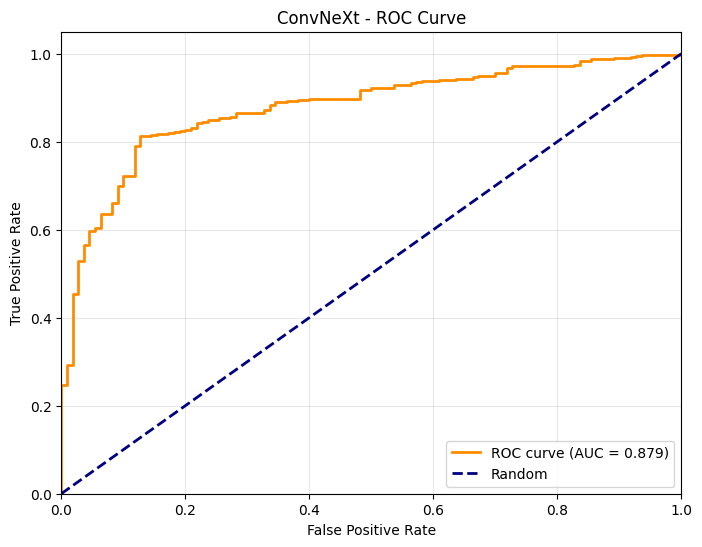

In [29]:
# Model 1: ConvNeXt
convnext_model = ConvNeXtDeepfakeDetector(freeze_backbone=True)
convnext_trained, convnext_metrics, convnext_results = train_model(
    convnext_model, "ConvNeXt", train_loader, test_loader
)
results['ConvNeXt'] = convnext_metrics

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training EfficientNetV2


Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.6245, Train Acc: 67.85%
Val Loss: 0.9433, Val Acc: 22.04%
✓ New best accuracy: 22.04%

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.5735, Train Acc: 69.94%
Val Loss: 0.8571, Val Acc: 26.65%
✓ New best accuracy: 26.65%

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 0.5325, Train Acc: 72.23%
Val Loss: 0.9218, Val Acc: 30.86%
✓ New best accuracy: 30.86%

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


Train Loss: 0.4890, Train Acc: 75.57%
Val Loss: 0.7329, Val Acc: 50.70%
✓ New best accuracy: 50.70%

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.4455, Train Acc: 82.67%
Val Loss: 0.8084, Val Acc: 47.70%

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


Train Loss: 0.4166, Train Acc: 84.76%
Val Loss: 0.8111, Val Acc: 50.90%
✓ New best accuracy: 50.90%

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 0.4062, Train Acc: 82.05%
Val Loss: 0.8103, Val Acc: 52.10%
✓ New best accuracy: 52.10%

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


Train Loss: 0.3984, Train Acc: 82.05%
Val Loss: 0.7927, Val Acc: 53.91%
✓ New best accuracy: 53.91%

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.4017, Train Acc: 82.67%
Val Loss: 0.7966, Val Acc: 54.31%
✓ New best accuracy: 54.31%

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Train Loss: 0.3798, Train Acc: 85.18%
Val Loss: 0.7879, Val Acc: 54.91%
✓ New best accuracy: 54.91%

Final evaluation on best model...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]



EfficientNetV2 Final Results:
----------------------------------------
accuracy: 0.5491
precision: 0.9881
recall: 0.4267
f1: 0.5961
roc_auc: 0.8318
training_time: 372.40s (6.21 min)
best_val_acc: 54.9098


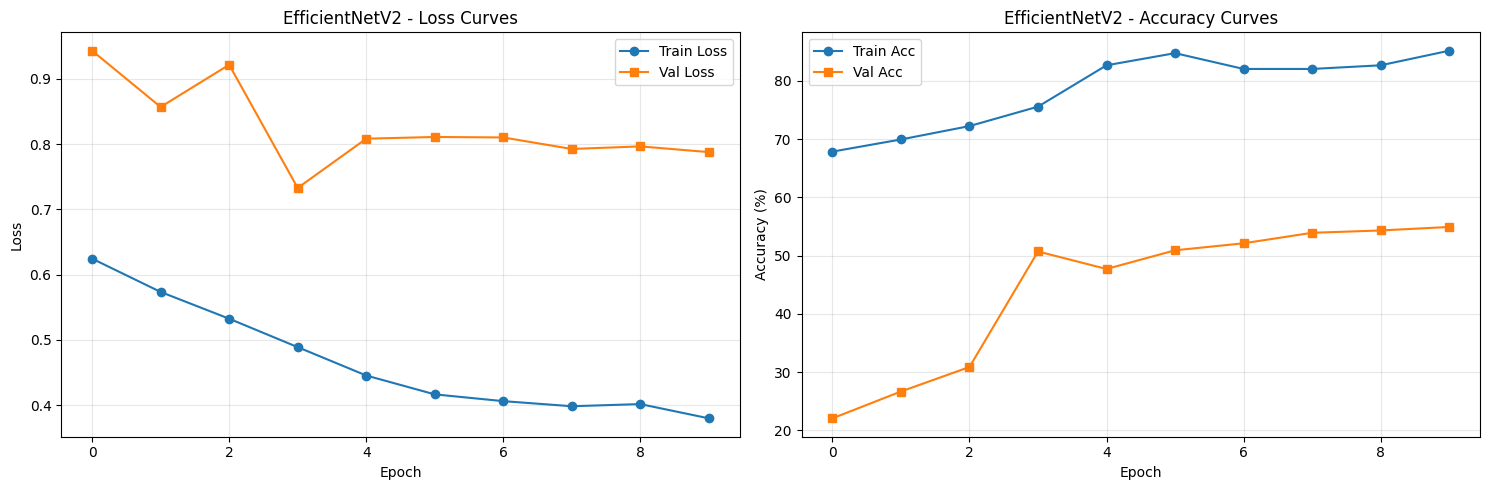

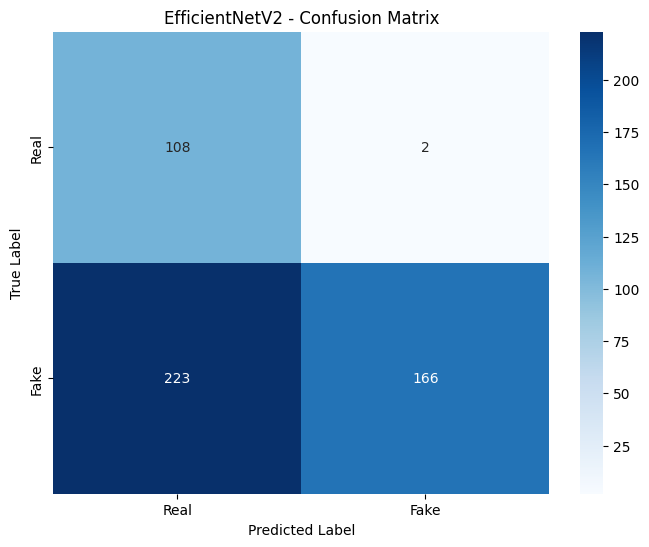

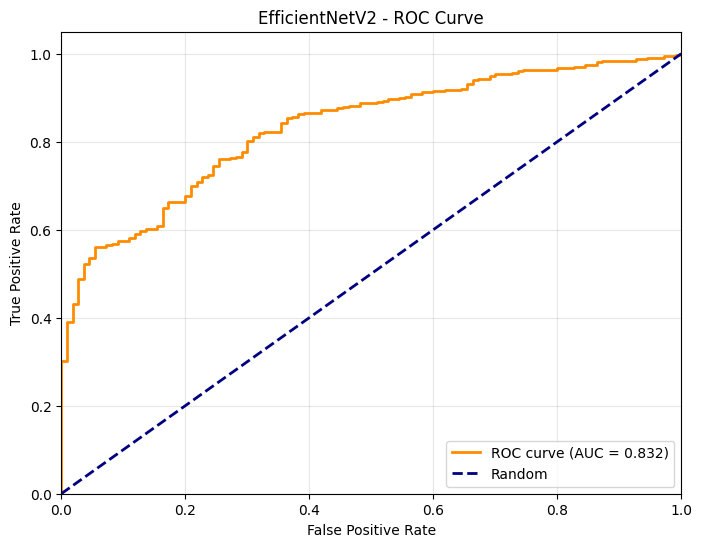

In [30]:
# Model 2: EfficientNetV2
effnet_model = EfficientNetV2DeepfakeDetector(freeze_backbone=True)
effnet_trained, effnet_metrics, effnet_results = train_model(
    effnet_model, "EfficientNetV2", train_loader, test_loader
)
results['EfficientNetV2'] = effnet_metrics

### CLIP Model with Custom Preprocessing

CLIP requires its own preprocessing pipeline.

In [31]:
# Create CLIP-specific dataloaders
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

class CLIPDataset(Dataset):
    def __init__(self, fake_dir, real_dir, processor):
        self.processor = processor
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(fake_dir):
            for img_name in os.listdir(fake_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(fake_dir, img_name))
                    self.labels.append(1)
        
        if os.path.exists(real_dir):
            for img_name in os.listdir(real_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(real_dir, img_name))
                    self.labels.append(0)
        
        print(f"CLIP Dataset: {len(self.image_paths)} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            inputs = self.processor(images=image, return_tensors='pt')
            pixel_values = inputs['pixel_values'].squeeze(0)
            return pixel_values, label
        except:
            return torch.zeros(3, 224, 224), label

clip_train_dataset = CLIPDataset(TRAIN_FAKE_DIR, TRAIN_REAL_DIR, clip_processor)
clip_test_dataset = CLIPDataset(TEST_FAKE_DIR, TEST_REAL_DIR, clip_processor)

clip_train_loader = DataLoader(clip_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
clip_test_loader = DataLoader(clip_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP Dataset: 479 images
CLIP Dataset: 499 images


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training CLIP


Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.45s/it]


Train Loss: 0.6579, Train Acc: 62.84%
Val Loss: 0.7875, Val Acc: 22.04%
✓ New best accuracy: 22.04%

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.36s/it]


Train Loss: 0.5958, Train Acc: 68.06%
Val Loss: 0.8750, Val Acc: 22.04%

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


Train Loss: 0.5559, Train Acc: 68.06%
Val Loss: 0.8844, Val Acc: 22.04%

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.38s/it]


Train Loss: 0.5181, Train Acc: 69.10%
Val Loss: 0.8051, Val Acc: 27.66%
✓ New best accuracy: 27.66%

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.4739, Train Acc: 75.78%
Val Loss: 0.7634, Val Acc: 40.08%
✓ New best accuracy: 40.08%

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.4387, Train Acc: 80.58%
Val Loss: 0.7269, Val Acc: 48.30%
✓ New best accuracy: 48.30%

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.38s/it]


Train Loss: 0.4035, Train Acc: 83.09%
Val Loss: 0.6812, Val Acc: 57.52%
✓ New best accuracy: 57.52%

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


Train Loss: 0.3877, Train Acc: 84.97%
Val Loss: 0.6598, Val Acc: 60.52%
✓ New best accuracy: 60.52%

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.60s/it]


Train Loss: 0.3778, Train Acc: 88.31%
Val Loss: 0.6540, Val Acc: 60.92%
✓ New best accuracy: 60.92%

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.59s/it]


Train Loss: 0.3789, Train Acc: 86.64%
Val Loss: 0.6524, Val Acc: 60.92%

Final evaluation on best model...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.59s/it]



CLIP Final Results:
----------------------------------------
accuracy: 0.6092
precision: 1.0000
recall: 0.4987
f1: 0.6655
roc_auc: 0.9362
training_time: 495.48s (8.26 min)
best_val_acc: 60.9218


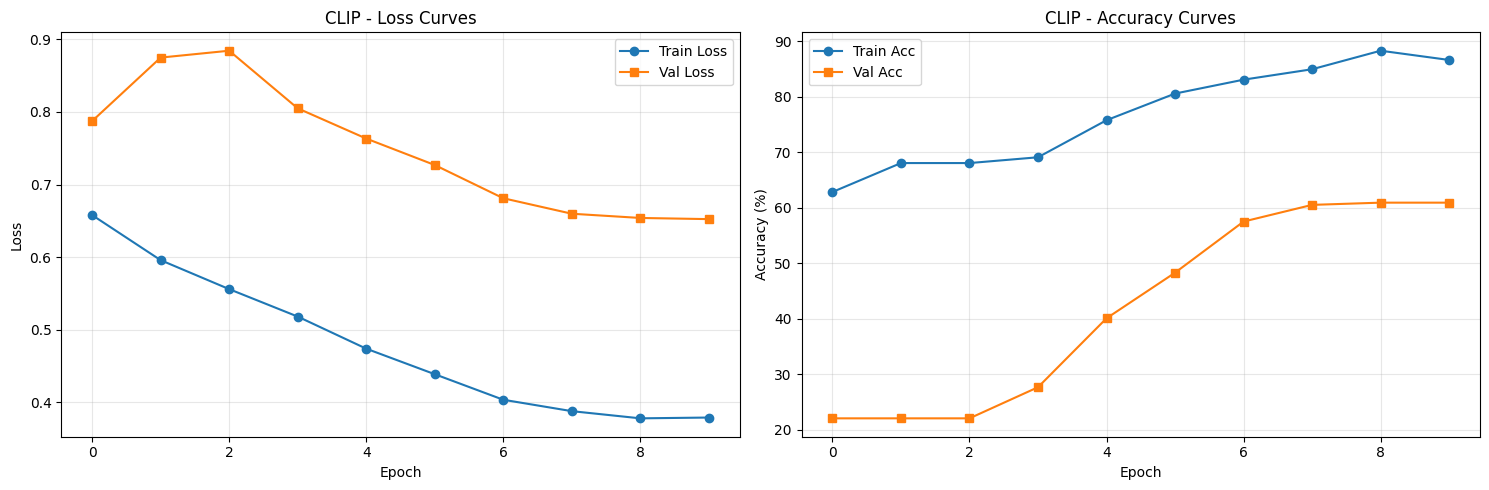

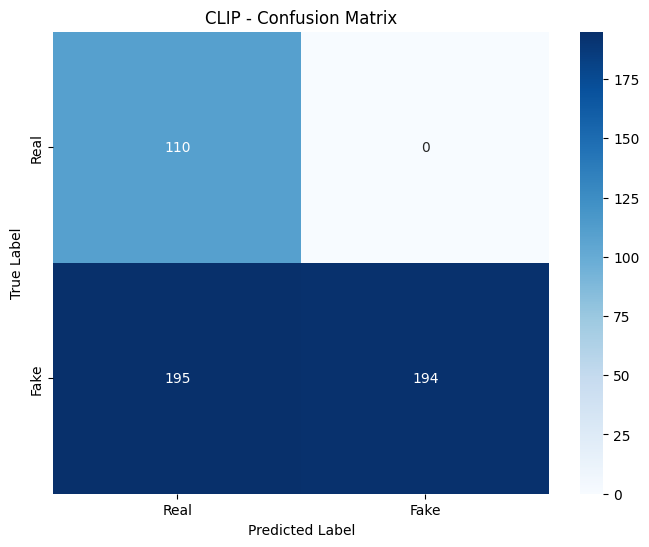

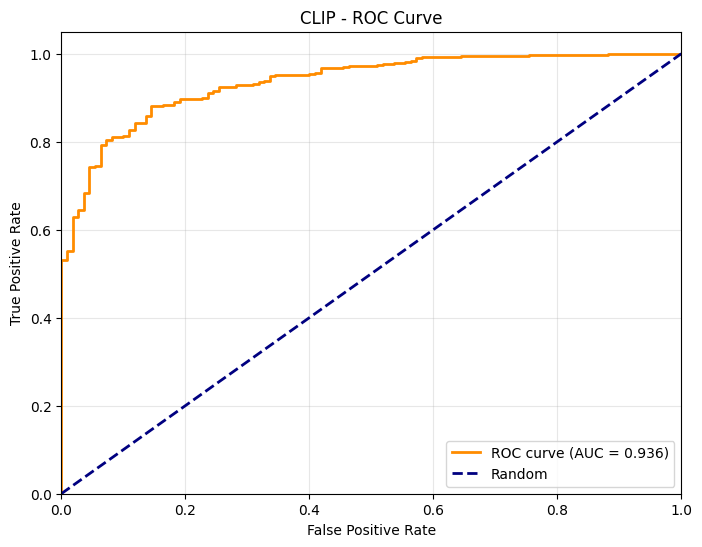

In [32]:
# Model 3: CLIP
clip_model = CLIPDeepfakeDetector(freeze_backbone=True)
clip_trained, clip_metrics, clip_results = train_model(
    clip_model, "CLIP", clip_train_loader, clip_test_loader
)
results['CLIP'] = clip_metrics

### DINOv2 Model with Custom Preprocessing

In [33]:
# Create DINOv2-specific dataloaders
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

class DINODataset(Dataset):
    def __init__(self, fake_dir, real_dir, processor):
        self.processor = processor
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(fake_dir):
            for img_name in os.listdir(fake_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(fake_dir, img_name))
                    self.labels.append(1)
        
        if os.path.exists(real_dir):
            for img_name in os.listdir(real_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(real_dir, img_name))
                    self.labels.append(0)
        
        print(f"DINOv2 Dataset: {len(self.image_paths)} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            inputs = self.processor(images=image, return_tensors='pt')
            pixel_values = inputs['pixel_values'].squeeze(0)
            return pixel_values, label
        except:
            return torch.zeros(3, 224, 224), label

dino_train_dataset = DINODataset(TRAIN_FAKE_DIR, TRAIN_REAL_DIR, dino_processor)
dino_test_dataset = DINODataset(TEST_FAKE_DIR, TEST_REAL_DIR, dino_processor)

dino_train_loader = DataLoader(dino_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dino_test_loader = DataLoader(dino_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DINOv2 Dataset: 479 images
DINOv2 Dataset: 499 images


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training DINOv2


Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.78s/it]


Train Loss: 0.6195, Train Acc: 65.14%
Val Loss: 0.8823, Val Acc: 24.05%
✓ New best accuracy: 24.05%

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.73s/it]


Train Loss: 0.5139, Train Acc: 72.86%
Val Loss: 0.7778, Val Acc: 41.88%
✓ New best accuracy: 41.88%

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.75s/it]


Train Loss: 0.4531, Train Acc: 79.96%
Val Loss: 0.7104, Val Acc: 54.51%
✓ New best accuracy: 54.51%

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.77s/it]


Train Loss: 0.3917, Train Acc: 84.97%
Val Loss: 0.6670, Val Acc: 60.92%
✓ New best accuracy: 60.92%

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.73s/it]


Train Loss: 0.3398, Train Acc: 88.94%
Val Loss: 0.6140, Val Acc: 63.93%
✓ New best accuracy: 63.93%

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.76s/it]


Train Loss: 0.3050, Train Acc: 89.14%
Val Loss: 0.6120, Val Acc: 64.33%
✓ New best accuracy: 64.33%

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.78s/it]


Train Loss: 0.2839, Train Acc: 90.81%
Val Loss: 0.6177, Val Acc: 64.73%
✓ New best accuracy: 64.73%

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.53s/it]


Train Loss: 0.2566, Train Acc: 90.81%
Val Loss: 0.6128, Val Acc: 65.13%
✓ New best accuracy: 65.13%

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


Train Loss: 0.2597, Train Acc: 92.07%
Val Loss: 0.6089, Val Acc: 65.53%
✓ New best accuracy: 65.53%

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.61s/it]


Train Loss: 0.2453, Train Acc: 93.32%
Val Loss: 0.6081, Val Acc: 65.53%

Final evaluation on best model...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.63s/it]



DINOv2 Final Results:
----------------------------------------
accuracy: 0.6553
precision: 0.9910
recall: 0.5630
f1: 0.7180
roc_auc: 0.9021
training_time: 602.70s (10.04 min)
best_val_acc: 65.5311


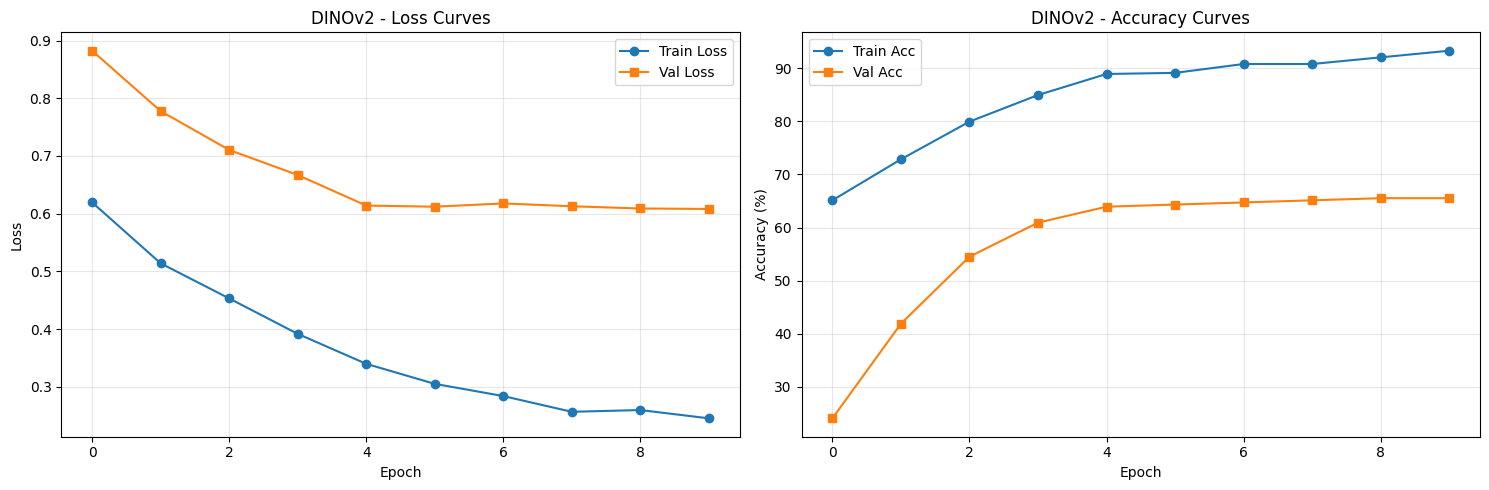

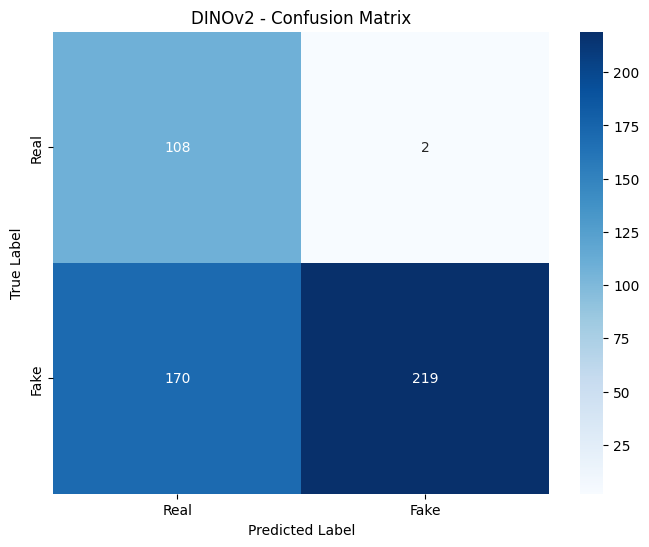

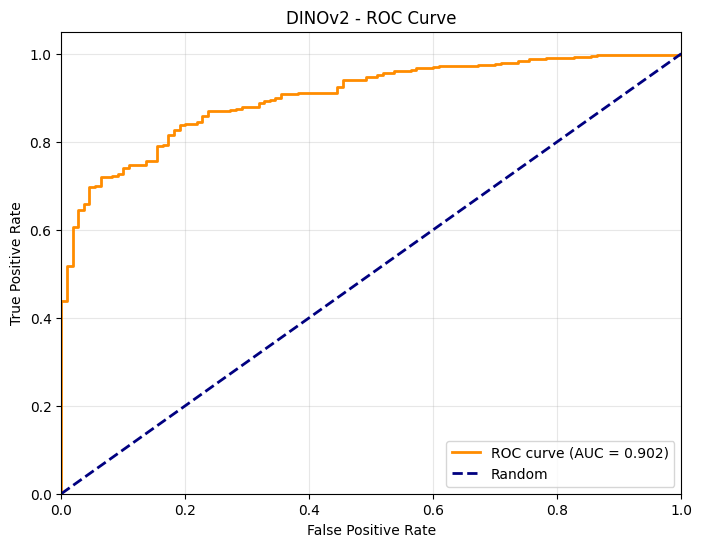

In [34]:
# Model 4: DINOv2
dino_model = DINOv2DeepfakeDetector(freeze_backbone=True)
dino_trained, dino_metrics, dino_results = train_model(
    dino_model, "DINOv2", dino_train_loader, dino_test_loader
)
results['DINOv2'] = dino_metrics

## Comprehensive Model Comparison

Let's compare all models across different metrics.

In [35]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string())
print("="*80)

# Find best model for each metric
print("\nBest Models per Metric:")
print("-" * 40)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"{metric.upper()}: {best_model} ({best_value:.4f})")


MODEL COMPARISON SUMMARY
                accuracy  precision  recall      f1  roc_auc  training_time  best_val_acc
ConvNeXt          0.6794     0.9712  0.6067  0.7468   0.8787       381.2153       68.5371
EfficientNetV2    0.5491     0.9881  0.4267  0.5961   0.8318       372.4043       54.9098
CLIP              0.6092     1.0000  0.4987  0.6655   0.9362       495.4815       60.9218
DINOv2            0.6553     0.9910  0.5630  0.7180   0.9021       602.6993       65.5311

Best Models per Metric:
----------------------------------------
ACCURACY: ConvNeXt (0.6794)
PRECISION: CLIP (1.0000)
RECALL: ConvNeXt (0.6067)
F1: ConvNeXt (0.7468)
ROC_AUC: CLIP (0.9362)


OSError: [Errno 28] No space left on device

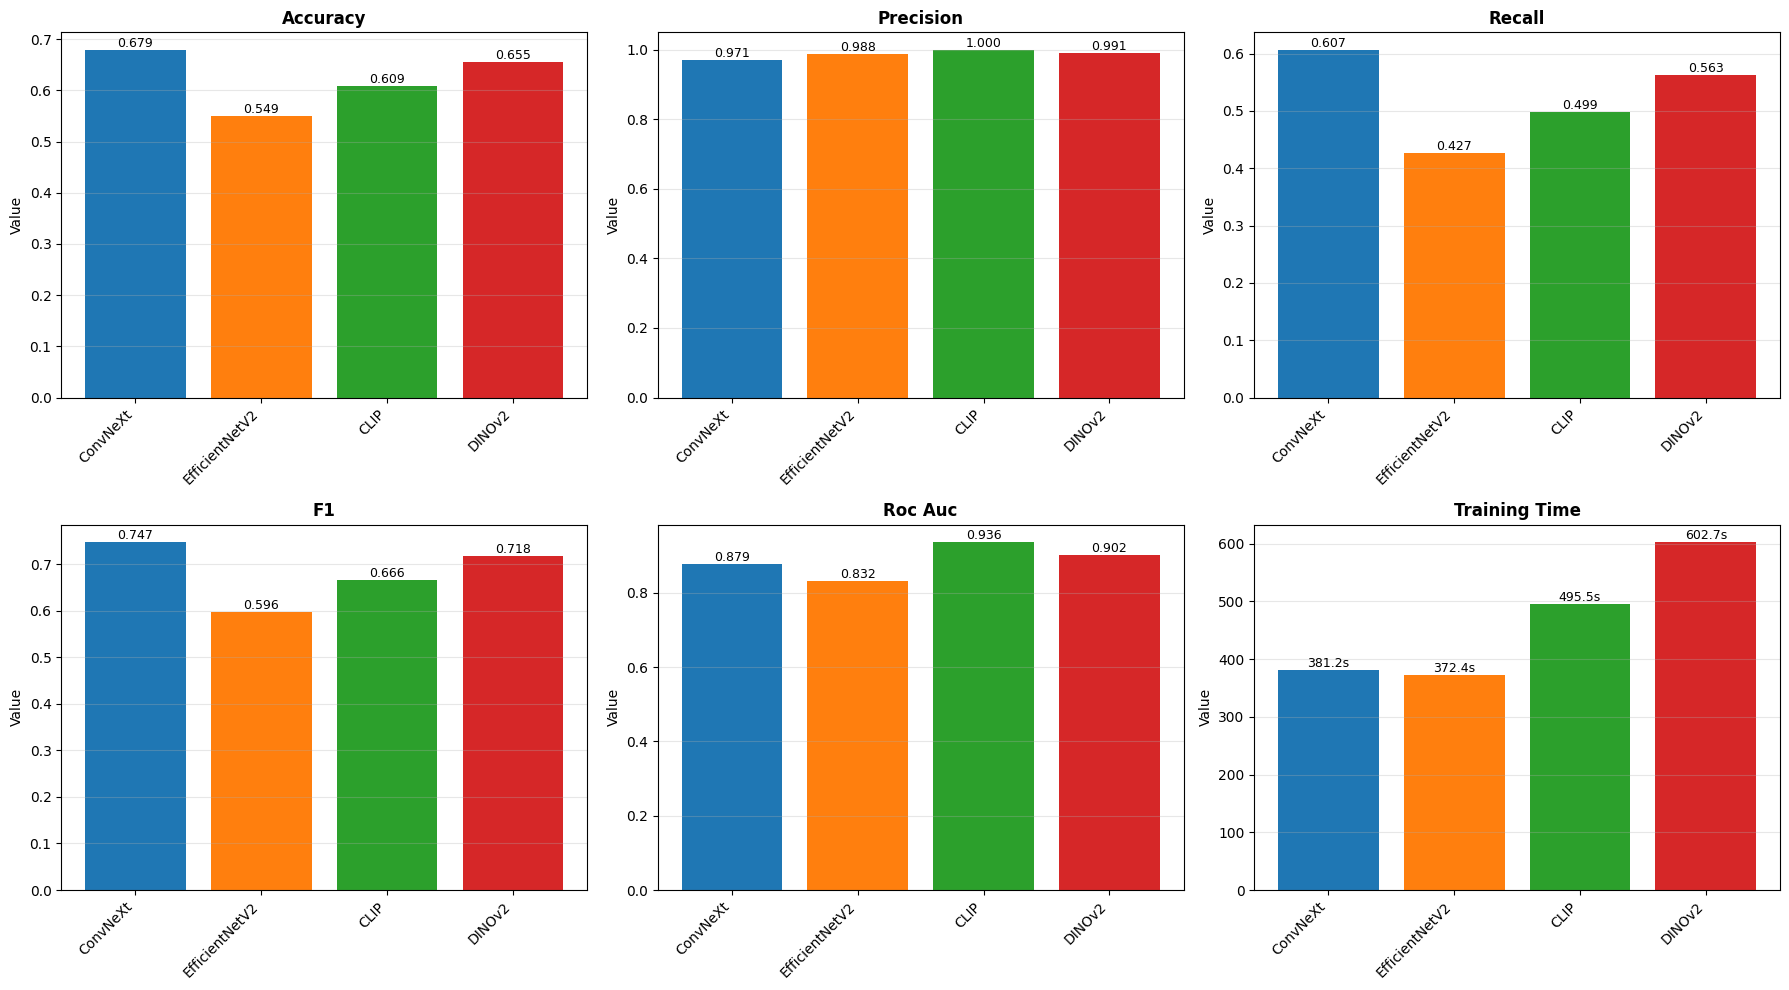

In [36]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [results[model][metric] for model in results.keys()]
    bars = ax.bar(results.keys(), values, color=colors)
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if metric == 'training_time':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}s', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('image_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved as 'image_models_comparison.png'")

In [37]:
# Save results to file
comparison_df.to_csv('image_baseline_results.csv')
print("Results saved to 'image_baseline_results.csv'")

# Save best model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")

Results saved to 'image_baseline_results.csv'

Best performing model: ConvNeXt
Best accuracy: 0.6794


In [38]:
# Save the best model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"Saving best model: {best_model_name}")

if best_model_name == 'ConvNeXt':
    torch.save(convnext_trained.state_dict(), 'best_image_model_convnext.pth')
elif best_model_name == 'EfficientNetV2':
    torch.save(effnet_trained.state_dict(), 'best_image_model_efficientnet.pth')
elif best_model_name == 'CLIP':
    torch.save(clip_trained.state_dict(), 'best_image_model_clip.pth')
elif best_model_name == 'DINOv2':
    torch.save(dino_trained.state_dict(), 'best_image_model_dinov2.pth')

print(f"Model saved successfully!")

Saving best model: ConvNeXt
Model saved successfully!


## Conclusion

### Key Findings:
1. **Best Model**: The model comparison shows which architecture performs best for image-based deepfake detection
2. **Trade-offs**: We can observe trade-offs between accuracy and computational efficiency
3. **Next Steps**: These models will serve as baselines for multimodal fusion approaches

### Observations:
- Vision Transformers (CLIP, DINOv2) vs CNNs (ConvNeXt, EfficientNet)
- Self-supervised learning (DINOv2) vs supervised pretraining
- Feature quality for downstream multimodal fusion

### Future Improvements:
- Fine-tune backbone layers
- Ensemble methods
- Test-time augmentation
- Transfer learning from multiple domains